In [ ]:
#default_exp core

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastai2.torch_basics import *
from fastai2.data.all import *
import torchaudio
import torchaudio.transforms as torchaud_tfm
import warnings

from IPython.display import display, Audio
from dataclasses import dataclass, asdict, is_dataclass, make_dataclass
from torchaudio.transforms import Spectrogram, AmplitudeToDB, MFCC
from librosa.display import specshow, waveplot
from inspect import signature
from functools import partial

# Core
> Core functionality for the fastai audio library.

# Audio Signals

## AudioGetter

This section regroups the basic types used in vision with the transform that create objects of those types.

In [ ]:
#export
audio_extensions = tuple(str.lower(k) for k, v in mimetypes.types_map.items() if v.startswith('audio/'))

In [ ]:
#export
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
def AudioGetter(suf='', recurse=True, folders=None):
    "Create `get_image_files` partial function that searches path suffix `suf` and passes along `kwargs`, only in `folders`, if specified."
    def _inner(o, recurse=recurse, folders=folders): 
        return get_audio_files(o/suf, recurse, folders)
    return _inner

In [ ]:
#export
URLs.SPEAKERS10 = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz'
URLs.SPEAKERS250 = 'https://public-datasets.fra1.digitaloceanspaces.com/250-speakers.tar'
URLs.ESC50 = 'https://github.com/karoldvl/ESC-50/archive/master.zip'

In [ ]:
#export
def tar_extract_at_filename(fname, dest):
    "Extract `fname` to `dest`/`fname`.name folder using `tarfile`"
    dest = Path(dest)/Path(fname).with_suffix('').name
    tarfile.open(fname, 'r:gz').extractall(dest)

In [ ]:
p = untar_data(URLs.SPEAKERS10, extract_func=tar_extract_at_filename)

In [ ]:
p.ls()

In [ ]:
audio_getter = AudioGetter("", recurse=True, folders=None)

In [ ]:
files = audio_getter(p)

In [ ]:
#files will load differently on different machines so we specify examples by name
ex_files = [p/f for f in ['m0005_us_m0005_00218.wav', 
                                'f0003_us_f0003_00279.wav', 
                                'f0001_us_f0001_00168.wav', 
                                'f0005_us_f0005_00286.wav',]]

## AudioItem

In [ ]:
#export
class AudioTensor(TensorBase):
    @classmethod
    @delegates(torchaudio.load, keep=True)
    def create(cls, fn, **kwargs):
        sig, sr = torchaudio.load(fn, **kwargs)
        return cls(sig, sr=sr)
    
    @property
    def sr(self): return self.get_meta('sr')
    
    def __new__(cls, x, sr, **kwargs):
        return super().__new__(cls, x, sr=sr, **kwargs)
    
    # This one should probably use set_meta() but there is no documentation,
    # and I could not get it to work. Even TensorBase.set_meta?? is pointing
    # to the wrong source because of fastai patch on Tensorbase to retain types
    @sr.setter
    def sr(self, val): self._meta['sr'] = val
    
    nsamples, nchannels = add_props(lambda i, self: self.shape[-1*(i+1)])
    @property
    def duration(self): return self.nsamples/float(self.sr)
    
    def hear(self):
        display(Audio(self, rate=self.sr))
    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        self.hear()
        show_audio_signal(self, ctx=ctx, **kwargs)
        plt.show()

Patch on indexing to retain the AudioTensor type, so when indexing it stays the same type

In [ ]:
#export
def _get_f(fn):
    def _f(self, *args, **kwargs):
        cls = self.__class__
        res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
        return retain_type(res, self)
    return _f
setattr(AudioTensor, '__getitem__', _get_f('__getitem__'))

In [ ]:
AudioTensor(torch.ones(10), sr=100)

In [ ]:
#export
def show_audio_signal(ai, ctx, **kwargs):
    if(ai.nchannels > 1):
        _,axs = plt.subplots(ai.nchannels, 1, figsize=(6,4*ai.nchannels))
        for i,channel in enumerate(ai):
            waveplot(channel.numpy(), ai.sr, ax=axs[i], **kwargs)
    else:
        axs = plt.subplots(ai.nchannels, 1)[1] if ctx is None else ctx 
        waveplot(ai.squeeze(0).numpy(), ai.sr, ax=axs, **kwargs)

In [ ]:
item0 = AudioTensor.create(ex_files[0])

In [ ]:
item0.shape

In [ ]:
item0.sr, item0.nchannels, item0.nsamples, item0.duration

In [ ]:
test_eq(type(item0.data), torch.Tensor)
test_eq(item0.sr, 16000)
test_eq(item0.nchannels, 1)
test_eq(item0.nsamples, 58240)
test_eq(item0.duration, 3.64)

In [ ]:
item0[0]

In [ ]:
item0.show()

In [ ]:
item1 = AudioTensor.create(files[1]);

In [ ]:
item0.show()
item1.show()

In [ ]:
#get 3 equal length portions of 3 different signals so we can stack them
#for a fake multichannel example
ai0, ai1, ai2 = map(AudioTensor.create, ex_files[1:4]);
min_samples = min(ai0.nsamples, ai1.nsamples, ai2.nsamples)
s0, s1, s2 = map(lambda x: x[:,:min_samples], (ai0, ai1, ai2))

In [ ]:
tst0 = AudioTensor(torch.ones(10), sr=120)
tst1 = AudioTensor(torch.ones(10), sr=150)
(tst0 + tst1).sr

In [ ]:
test_eq(s0.shape, s1.shape)
test_eq(s1.shape, s2.shape)

In [ ]:
fake_multichannel = AudioTensor(torch.stack((s0, s1, s2), dim=1).squeeze(0), sr=16000)

In [ ]:
test_eq(fake_multichannel.nchannels, 3)
test_eq(fake_multichannel.nsamples, 53760)

In [ ]:
fake_multichannel.show()

In [ ]:
#export
class OpenAudio(Transform):
    def __init__(self, items):
        self.items = items

    def encodes(self, i):
        o = self.items[i]
        return AudioTensor.create(o)
    
    def decodes(self, i)->Path: 
        return self.items[i]

repr of Transform is:  
classname: self.use_as_item {self.encodes} {self.decodes}  
encodes and decodes are TypeDispatches whose reprs are str of dict where k/v pair is typename and function that handles that type

In [ ]:
oa = OpenAudio(files); oa

In [ ]:
#demonstrate functionality of OpenAudio.encodes, the rest of the nb will
#use files that are opened by name for reproducibility/testing
oa = OpenAudio(files)
item100 = oa.encodes(100)
item100.show()

In [ ]:
#test open audio on a random set of files
for i in range(10):
    idx = random.randint(0, len(files)-1)
    test_eq_type(oa.encodes(idx), AudioTensor.create(files[idx]))
    test_eq_type(oa.decodes(idx), files[idx])

In [ ]:
type(oa)

In [ ]:
oa.encodes(0)

In [ ]:
oa.decodes(0)

In [ ]:
oa.items[0]

## Create functions to wrap TorchAudio

In [ ]:
#export
_GenSpec    = torchaudio.transforms.Spectrogram
_GenMelSpec = torchaudio.transforms.MelSpectrogram
_GenMFCC    = torchaudio.transforms.MFCC
_ToDB       = torchaudio.transforms.AmplitudeToDB

# Add AudioBlock

In [ ]:
#export
def AudioBlock(cls=AudioTensor): return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

# Audio Spectrograms

<div class='alert alert-block alert-warning'><strong>Note: </strong><br> Overriding getattr to store the settings isnt ideal, but if we dump them all in as attributes by doing `x.__dict__.update(settings)` we then can't easily pass settings when we do a transform and create a new AudioSpectrogram objct. Potential fixes are<br>
1. Having both a settings dict and updating the dict with all its attributes (this feels dirty)<br>
2. Finding a way to implement deepcopy for AudioSpectrogram so that we can clone it efficiently<br>
3. Dumping the spectrogram settings and having a method that collects them so it can be passed to the constructor when we make a new AudioSpectrogram object in a transform<br>

**Update: #2 is now a reasonable option because we mutate in place and dont need to pass settings forward**
</div>


## AudioSpectrogram Class

In [ ]:
#export
class AudioSpectrogram(TensorImageBase):
    @classmethod
    def create(cls, sg_tensor, settings=None):
        audio_sg = cls(sg_tensor)
        audio_sg._settings = settings
        return audio_sg
        
    @property
    def duration(self):
        # spectrograms round up length to fill incomplete columns,
        # so we subtract 0.5 to compensate, wont be exact
        return (self.hop_length*(self.shape[-1]-0.5))/self.sr
    
    height, width = add_props(lambda i, self: self.shape[i+1], n=2)
    #using the line below instead of above will fix show_batch but break multichannel/delta display
    #nchannels, height, width = add_props(lambda i, self: self.shape[i], n=3)
    
    def __getattr__(self, name):
        if name == "settings": return self._settings
        if not name.startswith('_'): return self._settings[name]
        raise AttributeError(f"{self.__class__.__name__} object has no attribute {name}")
        
    def show(self, ctx=None, ax=None, figsize=None, **kwargs):
        show_spectrogram(self, ctx=ctx, ax=ax, figsize=figsize,**kwargs)
        plt.show()

<div class='alert alert-block alert-info'><strong>TO-DO:</strong><br>
    1. Get colorbar and axes working for multiplot display <br>
    2. Have someone who knows matplotlib better cleanup/refactor<br>
    3. Plotting the spectrogram forces it to a uniform size, we may want to display either the
    shape of the image, or display it to scale with something like plt.figure(figsize=(sg.width/30, sg.height/30))
</div>

In [ ]:
#export 
def show_spectrogram(sg, ax, ctx, figsize, **kwargs):
    ax = ifnone(ax,ctx)
    nchannels = sg.nchannels
    r, c = nchannels, sg.data.shape[0]//nchannels
    proper_kwargs = get_usable_kwargs(specshow, sg._settings, exclude=["ax", "kwargs", "data",])
    if (r == 1 and c == 1):
        _show_spectrogram(sg, ax, proper_kwargs, **kwargs)
        plt.title("Channel 0 Image 0: {} X {}px".format(*sg.shape[-2:]))
    else:
        if figsize is None: figsize = (4*c, 3*r)
        if ax is None: _,ax = plt.subplots(r, c, figsize=figsize)
        for i, channel in enumerate(sg.data):
            if r == 1:
                cur_ax = ax[i%c]
            elif c == 1:
                cur_ax = ax[i%r]
            else:
                cur_ax = ax[i//c,i%c]
            width,height = sg.shape[-2:]
            cur_ax.set_title(f"Channel {i//c} Image {i%c}: {width} X {height}px")
            z = specshow(channel.numpy(), ax=cur_ax, **sg._show_args, **proper_kwargs)
            #plt.colorbar(z, ax=cur_ax)
            #ax=plt.gca() #get the current axes
            #PCM=ax.get_children()[2] #get the mappable, the 1st and the 2nd are the x and y axes
            #plt.colorbar(PCM, ax=ax, format='%+2.0f dB') 
            
def _show_spectrogram(sg, ax, proper_kwargs, **kwargs):
    if "mel" not in sg._settings: y_axis = None
    else:                        y_axis = "mel" if sg.mel else "linear"
    proper_kwargs.update({"x_axis":"time", "y_axis":y_axis,})
    _ = specshow(sg.data.squeeze(0).numpy(), **sg._show_args, **proper_kwargs)
    fmt = '%+2.0f dB' if "to_db" in sg._settings and sg.to_db else '%+2.0f'
    plt.colorbar(format=fmt)

## Spectrogram Generation: AudioToSpec

In [ ]:
#export
class AudioToSpec(Transform):
    def __init__(self, pipe, settings):
        self.pipe = pipe
        self.settings = settings
    
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else dict(audio_cfg)
        transformer = SpectrogramTransformer(mel=cfg.pop("mel"), to_db=cfg.pop("to_db"))
        return transformer(**cfg)
    
    def encodes(self, audio:AudioTensor):
        self.settings.update({'sr':audio.sr, 'nchannels':audio.nchannels})
        return AudioSpectrogram.create(self.pipe(audio.data), settings=dict(self.settings))

In [ ]:
#export
def SpectrogramTransformer(mel=True, to_db=True):
    sg_type = {"mel":mel, "to_db":to_db}
    transforms = _get_transform_list(sg_type)
    pipe_noargs = partial(fill_pipeline, sg_type=sg_type, transform_list=transforms)
    pipe_noargs.__signature__ = _get_signature(transforms)
    return pipe_noargs

def _get_transform_list(sg_type):
    '''Builds a list of higher-order transforms with no arguments'''
    transforms = L()
    if sg_type["mel"]:   transforms += _GenMelSpec
    else:                transforms += _GenSpec
    if sg_type["to_db"]: transforms += _ToDB
    return transforms

def fill_pipeline(transform_list, sg_type, **kwargs):
    '''Adds correct args to each transform'''
    kwargs = _override_bad_defaults(dict(kwargs))
    function_list = L()
    settings = {}
    for f in transform_list:
        usable_kwargs = get_usable_kwargs(f, kwargs)
        function_list += f(**usable_kwargs)
        settings.update(usable_kwargs)
    warn_unused(kwargs, settings)
    return AudioToSpec(Pipeline(function_list), settings={**sg_type, **settings})

def _get_signature(transforms):
    '''Looks at transform list and extracts all valid args for tab completion'''
    delegations = [delegates(to=f, keep=True) for f in transforms]
    out = lambda **kwargs: None
    for d in delegations: out = d(out)
    return signature(out)
        
def _override_bad_defaults(kwargs):
    if "n_fft" not in kwargs or kwargs["n_fft"] is None:            kwargs["n_fft"] = 1024
    if "win_length" not in kwargs or kwargs["win_length"] is None:  kwargs["win_length"] = kwargs["n_fft"] 
    if "hop_length" not in kwargs or kwargs["hop_length"] is None:  kwargs["hop_length"] = int(kwargs["win_length"]/2)
    return kwargs

def warn_unused(all_kwargs, used_kwargs):
    unused_kwargs = set(all_kwargs.keys()) - set(used_kwargs.keys())
    for kwarg in unused_kwargs:
        warnings.warn(f"{kwarg} is not a valid arg name and was not used")

<div class='alert alert-block alert-warning'><strong>Note: </strong><br>The <code>function_list += f(**usable_kwargs)</code> only works if all args are keyword arguments, doesnt work for unnamed args. Could add in a get usable args that checks if default is inspect._empty. This also needs more tests</div>  

<div class='alert alert-block alert-warning'><strong>Note: </strong><br> If a function (e.g. specshow) accepts kwargs, this wont pass extra arguments because specshow doesnt accept all kwargs, and will break if you pass in unexpected ones, but we have no way of knowing what functions they delegate to and pulling out the relevant kwargs, so if there is something we know it accepts as a kwarg like "cmap" we need to pass it in manually  </div>

`get_usable_kwargs` takes a function and a dictionary of kwargs that may or may not be relevant to that function and returns a dictionary of all the default values to that function, updated with the kwargs that can be successfully applied. This is done because, first it allows us to combine multiple functions into a single AudioToSpec Transform but only pass the appropriate kwargs, secondly because it allows us to keep a dictionary of the settings used to create the Spectrogram which is sometimes used in it's display and cropping, and third because it allows us to warn the user when they are passing in improper or unused kwargs.

In [ ]:
#export
def get_usable_kwargs(func, kwargs, exclude=None):
    exclude = ifnone(exclude, [])
    defaults = {k:v.default for k, v in inspect.signature(func).parameters.items() if k not in exclude}
    usable = {k:v for k,v in kwargs.items() if k in defaults}
    return {**defaults, **usable}

Example: testing with a function that only takes ```a``` and ```b``` as kwargs

In [ ]:
def test_kwargs(a:int=10, b:int=20): pass

kwargs = {'a':1, 'b':2}
extra_kwargs = {'z':0, 'a':1, 'b':2, 'c':3}
test_eq(get_usable_kwargs(test_kwargs,       kwargs    ), kwargs)
test_eq(get_usable_kwargs(test_kwargs, extra_kwargs, []), kwargs)

In [ ]:
item0 = AudioTensor.create(ex_files[0])

In [ ]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [ ]:
a2s = DBMelSpec(n_fft=2048, hop_length=128, n_mels=64, baloney="hi")

In [ ]:
type(item0)

In [ ]:
item0.__dict__

`<<<<<<< HEAD`

In [ ]:
a2s

In [ ]:
sg = a2s(item0)

In [ ]:
item0.__dict__

In [ ]:
type(item0)

In [ ]:
item0.shape

In [ ]:
sg.shape

In [ ]:
sg.settings

In [ ]:
sg.show()

`=======`

In [ ]:
sg.show()

`>>>>>>> master`

### Display and Testing

In [ ]:
# get a sg with weird settings for testing
item0 = AudioTensor.create(ex_files[0])
item1 = AudioTensor.create(ex_files[1])
a2s = DBMelSpec(f_max = 20000, n_mels=137)
sg = a2s(item0)
sg1 = a2s(item1)

In [ ]:
sg.show()
sg1.show()

In [ ]:
sg_mc = a2s(fake_multichannel)

In [ ]:
sg_mc.show()

In [ ]:
sg.shape

In [ ]:
sg._settings

In [ ]:
sg.nchannels, sg.height, sg.width

In [ ]:
#test the explicit settings were properly stored in the spectrogram object and can be accessed as attributes
test_eq(sg.f_max, 20000)
test_eq(sg.hop_length, 512)
test_eq(sg.sr, item100.sr)
test_eq(sg.mel, True)
test_eq(sg.to_db, True)
test_eq(sg.nchannels, 1)
test_eq(sg.height, 137)
test_eq(sg.n_mels, sg.height)
test_eq(sg.width, 114)

In [ ]:
defaults = {k:v.default for k, v in inspect.signature(_GenMelSpec).parameters.items()}
a2s = DBMelSpec(f_max =20000, hop_length=345)
sg = a2s(item100)
test_eq(sg.n_mels, defaults["n_mels"])
test_eq(sg.n_fft , 1024)
test_eq(sg.shape[1], sg.n_mels)
test_eq(sg.hop_length, 345)

In [ ]:
# test the spectrogram and audio have same duration, both are computed
# on the fly as transforms can change their duration
test_close(sg.duration, item100.duration, eps=0.1)

#### Test if spectrograms are right-side up

In [ ]:
a2s_5hz = DBMelSpec(
    sample_rate=16000,
    n_fft=1024,
    win_length=1024,
    hop_length=512,
    f_min=0.0,
    f_max=20000,
    pad=0,
    n_mels=137,
)

In [ ]:
sine_5hz = torch.Tensor([0.5 * np.cos(2 * np.pi * 5 * np.arange(0, 1.0, 1.0/16000))])

In [ ]:
at_5hz = AudioTensor(sine_5hz, 16000)

In [ ]:
sg_5hz = a2s_5hz(at_5hz)

In [ ]:
sg_5hz.show()

In [ ]:
# testing to make sure the lowest bin of the spectrogram has the highest value/most energy
max_row = sg_5hz.max(dim=1).indices.mode().values.item()
assert max_row < 2

### Test warnings for missing/extra arguments

In [ ]:
SHOW_W=True

In [ ]:
#test warning for unused argument 'power' for melspec
#tests AudioToSpec and its from_cfg class method
voice_mel_cfg = {'mel':True, 'to_db':True, 'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256, 'power':2}
test_warns(lambda: AudioToSpec.from_cfg(voice_mel_cfg), show=SHOW_W)

In [ ]:
test_warns(lambda: DBMelSpec(power=2, n_fft=2560, f_max=22050, n_mels=128), show=SHOW_W)

In [ ]:
#test for unused arguments 'f_max' and 'n_mels' for non-mel Spectrogram
voice_mel_cfg = {'mel':False, 'to_db':True, 'f_max':22050., 'n_mels':128, 'n_fft':2560, 'hop_length':256, 'power':2}
test_warns(lambda: AudioToSpec.from_cfg(voice_mel_cfg), show=SHOW_W)

<class 'UserWarning'>: f_max is not a valid arg name and was not used
<class 'UserWarning'>: n_mels is not a valid arg name and was not used


In [ ]:
#test warning for unused argument 'top_db' when db conversion not done
voice_mel_cfg = {'mel':True, 'to_db':False, 'top_db':20, 'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
test_warns(lambda: AudioToSpec.from_cfg(voice_mel_cfg), show=SHOW_W)

In [ ]:
#test warning for invalid argument 'doesntexist'
voice_mel_cfg = {'mel':True, 'to_db':True,'doesntexist':True, 'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
test_warns(lambda: AudioToSpec.from_cfg(voice_mel_cfg), show=SHOW_W)

#### AudioToSpec Timing Tests

In [ ]:
a_to_db_mel = SpectrogramTransformer()()
a_to_nondb_mel = SpectrogramTransformer(to_db=False)()
a_to_db_nonmel = SpectrogramTransformer(mel=False)()
a_to_nondb_non_mel = SpectrogramTransformer(mel=False, to_db=False)()
a_to_db_mel_hyperparams = SpectrogramTransformer()(n_fft=8192, hop_length=128)

In [ ]:
%%timeit -n10
a_to_db_mel(item0)

1.57 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
a_to_nondb_mel(item0)

<<<<<<< local <modified: >


The slowest run took 4.17 times longer than the fastest. This could mean that an intermediate result is being cached.
1.54 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


>>>>>>> remote <removed>


In [ ]:
%%timeit -n10
a_to_nondb_mel(item0)

1.34 ms ± 938 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
a_to_db_nonmel(item0)

<<<<<<< local <modified: >


1.11 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


>>>>>>> remote <removed>


In [ ]:
%%timeit -n10
a_to_nondb_non_mel(item0)

<<<<<<< local <modified: >


915 µs ± 186 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


>>>>>>> remote <removed>


In [ ]:
%%timeit -n10
# Time can blow up as a factor of n_fft and hop_length. n_fft is best kept to a power of two, hop_length
# doesn't matter except smaller = more time because we have more chunks to perform STFTs on
a_to_db_mel_hyperparams(item0)

<<<<<<< local <modified: >


21.8 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


>>>>>>> remote <removed>


#### AudioToSpec Timing Tests as audio length scales

In [ ]:
import time
def time_variable_length_audios(f, max_seconds=30, sr=16000, channels=1):
    times = []
    audios = [AudioTensor(torch.randn(channels, sr*i), sr) for i in range(1,max_seconds+1,2)]
    for a in audios:
        start = time.time()
        out = f(a)
        end = time.time()
        times.append(round(1000*(end-start), 2))
    return times

<<<<<<< local <modified: >


CPU times: user 21.9 s, sys: 3.86 s, total: 25.7 s
Wall time: 8.33 s


>>>>>>> remote <removed>


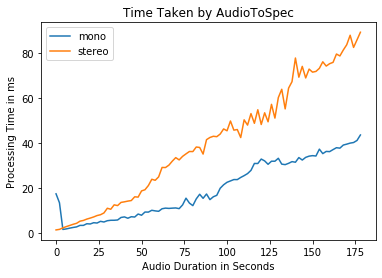

In [ ]:
%%time
a2s = SpectrogramTransformer()()
max_seconds = 180
times_mono = time_variable_length_audios(f=a2s, max_seconds=max_seconds)
times_stereo = time_variable_length_audios(f=a2s, max_seconds=max_seconds, channels=2)
plt.plot(np.arange(0,max_seconds,2), times_mono, label="mono")
plt.plot(np.arange(0,max_seconds,2), times_stereo, label="stereo")
plt.legend(['mono','stereo'])
plt.title("Time Taken by AudioToSpec")
plt.xlabel("Audio Duration in Seconds")
plt.ylabel("Processing Time in ms")

## MFCC Generation

<div class='alert alert-block alert-warning'><strong>Issue:</strong><br>
    MFCC is based on a melspectrogram so it accepts a bunch of the same arguments, but instead of passing them in explicitly, they are passed as a dict to "melkwargs". As a result, in the current state the mfcc has no current info about the hop_length (determines the width) that it was generated with. One option is grabbing the defaults from _GenMelSpec inside AudioToMFCC and pass it into the sg_settings. OTOH this could be an argument for lumping everything into AudioToSpec, including MFCC, and then we'd have the same access to _GenMelSpec arguments for tab-completion. We could also make AudioToMFCC have a 2nd delegation to _GenMelSpec, and then parse the MelSpec arguments ourselves and bundle them into melkwargs before passing them to torchaudio. This would break our concept of wrapping the external functions in internal references like _GenMelSpec, because we'd no longer be agnostic to how theyre implemented. One last note is that melkwargs will not accept extra keywords, only the ones that torchaudio.transforms.MelSpectrogram expects. <br>
</div>

In [ ]:
#export
@delegates(_GenMFCC.__init__)
class AudioToMFCC(Transform):
    def __init__(self,**kwargs):
        func_args = get_usable_kwargs(_GenMFCC, kwargs, [])
        self.transformer = _GenMFCC(**func_args)
        self.settings = func_args
        
    @classmethod
    def from_cfg(cls, audio_cfg):
        cfg = asdict(audio_cfg) if is_dataclass(audio_cfg) else audio_cfg
        return cls(**cfg)
    
    def encodes(self, x:AudioTensor):
        sg_settings = {"sr":x.sr, 'nchannels':x.nchannels, **self.settings}
        return AudioSpectrogram.create(self.transformer(x).detach(), settings=sg_settings)

In [ ]:
item0 = AudioTensor.create(ex_files[0])
a2mfcc = AudioToMFCC()
mfcc = a2mfcc(item0)
test_eq(mfcc.n_mfcc, mfcc.data.shape[1])

In [ ]:
mfcc.show()

In [ ]:
mfcc._settings

In [ ]:
mfcc.height

In [ ]:
mfcc.width

In [ ]:
#n_mfcc specified should determine the height of the mfcc
item1 = AudioTensor.create(ex_files[1])
n_mfcc = 67
a2mfcc67 = AudioToMFCC(n_mfcc=n_mfcc)
mfcc67 = a2mfcc67(item1)
test_eq(mfcc67.shape[1], n_mfcc)
print(mfcc67.shape)
mfcc67.show()

### Example of passing in melkwargs 

In [ ]:
a2mfcc_kwargs = AudioToMFCC(melkwargs={"hop_length":1024, "n_fft":1024})
mfcc_kwargs = a2mfcc_kwargs(item1)
mfcc_kwargs.show()
# make sure a new hop_length changes the resulting width
test_ne(mfcc_kwargs.width, mfcc.width)

#### MFCC Timing Tests

<<<<<<< local <modified: >


CPU times: user 28.8 s, sys: 1.97 s, total: 30.7 s
Wall time: 9.56 s


>>>>>>> remote <removed>


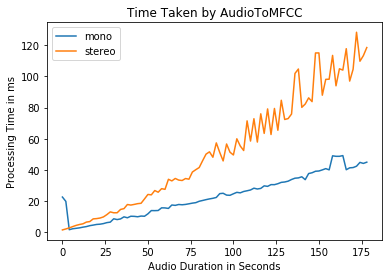

In [ ]:
%%time
a2mfcc = AudioToMFCC()
max_seconds = 180
times_mono = time_variable_length_audios(f=a2mfcc, max_seconds=max_seconds)
times_stereo = time_variable_length_audios(f=a2mfcc, max_seconds=max_seconds, channels=2)
plt.plot(np.arange(0,max_seconds,2), times_mono, label="mono")
plt.plot(np.arange(0,max_seconds,2), times_stereo, label="stereo")
plt.legend(['mono','stereo'])
plt.title("Time Taken by AudioToMFCC")
plt.xlabel("Audio Duration in Seconds")
plt.ylabel("Processing Time in ms")

# Example Pipelines

### DB MelSpectrogram Pipe (Standard)

In [ ]:
mel_cfg = {'n_fft':2560,'hop_length':64}
oa = OpenAudio(files)
a2s = DBMelSpec(**mel_cfg)
db_mel_pipe = Pipeline([oa,a2s])
for i in range(5):
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Raw Spectrogram (non-mel, non-db) Pipe

In [ ]:
cfg = {'mel':False, 'to_db':False, 'hop_length':128, 'n_fft':400}
oa = OpenAudio(files)
a2s = AudioToSpec.from_cfg(cfg)
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3):
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))
    test_eq(db_mel_pipe(i).hop_length, cfg["hop_length"])

### DBScale non-melspectrogram Pipe

In [ ]:
oa = OpenAudio(files)
a2s = SpectrogramTransformer(mel=False)()
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3): 
    print("Shape:", db_mel_pipe(i).shape)
    db_mel_pipe.show(db_mel_pipe(i))

### Pipe using from_cfg (config)

In [ ]:
#non-mel db-scale spectrogram, warning is expected as f_max is an argument to melspectrograms
cfg = {'mel':False, 'to_db':True, 'n_fft':260, 'f_max':22050., 'hop_length':128}
oa = OpenAudio(files)
a2s = AudioToSpec.from_cfg(cfg)
db_mel_pipe = Pipeline([oa, a2s])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

### MFCC Pipe

In [ ]:
db_mfcc_pipe = Pipeline([oa, AudioToMFCC(n_mfcc=40),])
for i in range(3): 
    db_mfcc_pipe.show(db_mfcc_pipe(i))

# AudioConfig Class

In [ ]:
#export
def config_from_func(func, name, **kwargs):
    params = inspect.signature(func).parameters.items()
    namespace = {k:v.default for k, v in params}
    namespace.update(kwargs)
    return make_dataclass(name, namespace.keys(), namespace=namespace)

In [ ]:
#export
class AudioConfig():
    #default configurations from the wrapped function
    #make sure to pass in mel=False as kwarg for non-mel spec, and to_db=False for non db spec
    BasicSpectrogram    = config_from_func(_GenSpec, "BasicSpectrogram", mel=False, to_db=True)
    BasicMelSpectrogram = config_from_func(_GenMelSpec, "BasicMelSpectrogram", mel=True, to_db=True)
    BasicMFCC           = config_from_func(_GenMFCC, "BasicMFCC ")
    #special configs with domain-specific defaults

    Voice = config_from_func(_GenMelSpec, "Voice", mel="True", to_db="False", f_min=50., f_max=8000., n_fft=1024, n_mels=128, hop_length=128)

`<<<<<<< HEAD`

In [ ]:
oa(42)

In [ ]:
# Basic Mel Spectrogram is just the Torchaudio defaults, which are currently bad, hence
# the empty melbins in the spectrogram below. We can make our own custom good ones like Voice
mel_cfg = AudioConfig.BasicMelSpectrogram()
a2mel = AudioToSpec.from_cfg(mel_cfg)
item0 = AudioTensor.create(ex_files[0])
mel_bad = a2mel(item0)
mel_bad.show()
voice_cfg = AudioConfig.Voice()
a2mel = AudioToSpec.from_cfg(voice_cfg)
mel_good = a2mel(oa(42))
mel_good.show()

`=======`

In [ ]:
# Basic Mel Spectrogram is just the Torchaudio defaults, which are currently bad, hence
# the empty melbins in the spectrogram below. We can make our own custom good ones like Voice
mel_cfg = AudioConfig.BasicMelSpectrogram()
a2mel = AudioToSpec.from_cfg(mel_cfg)
item0 = AudioTensor.create(ex_files[0])
mel_bad = a2mel(item0)
mel_bad.show()
voice_cfg = AudioConfig.Voice()
a2mel = AudioToSpec.from_cfg(voice_cfg)
mel_good = a2mel(oa(42))
mel_good.show()

`>>>>>>> master`

In [ ]:
test_eq(mel_bad.n_fft, mel_cfg.n_fft)
# hop defaults to None in torchaudio but is set later in the code, we override this default to None
# internally in AudioToSpec to ensure the correct hop_length is stored as a sg attribute
test_ne(mel_bad.hop_length, mel_cfg.hop_length)
print("MelConfig Default Hop:", mel_cfg.hop_length)
print("Resulting Hop:",mel_bad.hop_length)

In [ ]:
sg_cfg = AudioConfig.BasicSpectrogram()
# make sure mel setting is passed down and is false for normal spectro
test_eq(sg_cfg.mel, False)

In [ ]:
#Grab a random file, test that the n_fft are passed successfully via config and stored in sg settings
oa = OpenAudio(files)
f_num = random.randint(0, len(files))
sg_cfg = AudioConfig.BasicSpectrogram(n_fft=2000, hop_length=155)
a2sg = AudioToSpec.from_cfg(sg_cfg)
sg = a2sg(oa(f_num))
test_eq(sg.n_fft, sg_cfg.n_fft)
test_eq(sg.width, int(oa(f_num).nsamples/sg_cfg.hop_length)+1)

## Pipeline examples from Config

In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg)])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
voice_config = AudioConfig.Voice(); voice_config

<<<<<<< local <modified: text/plain>


Voice(sample_rate=16000, n_fft=1024, win_length=None, hop_length=128, f_min=50.0, f_max=8000.0, pad=0, n_mels=128, window_fn=<built-in method hann_window of type object at 0x7f550ea6bbe0>, wkwargs=None, mel='True', to_db='False')

>>>>>>> remote <removed>


In [ ]:
oa = OpenAudio(files)
db_mel_pipe = Pipeline([oa, AudioToSpec.from_cfg(voice_config)])
for i in range(3): 
    db_mel_pipe.show(db_mel_pipe(i))

In [ ]:
mfcc_cfg = AudioConfig.BasicMFCC()
oa = OpenAudio(files)
mfcc_pipe = Pipeline([oa, AudioToMFCC.from_cfg(mfcc_cfg)])
for i in range(44,47):
    print("Shape", mfcc_pipe(i).shape)
    mfcc_pipe(i).show()

## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()